In [1]:
import sklearn as skl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

plt.set_cmap('gray')
catsAndDogs = pd.read_csv('./CATSnDOGS.csv')
labels = np.ravel(pd.read_csv("./Labels.csv"))

<Figure size 640x480 with 0 Axes>

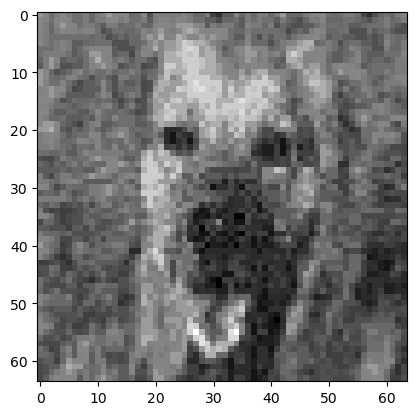

In [2]:
animal = catsAndDogs.loc[6]                   ## Retrieve animal at row
animal = animal.values.reshape((64,64)).T     ## Reshape to 64x64 and transpose to get correct orientation

plt.imshow(animal)
X_train_clean, X_test, y_train_clean, y_test = train_test_split(catsAndDogs, labels, test_size=0.2, random_state=1234567)


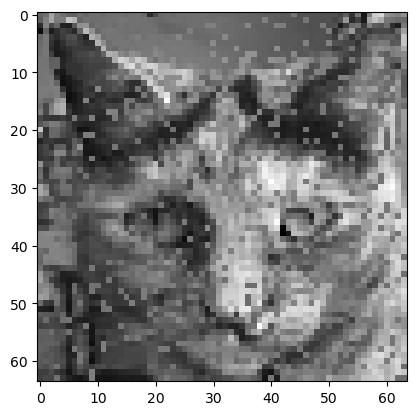

In [3]:
## Pollute Datasets
## Polluting at 2 different levels
## Random Forest Feature Importance

forest = RandomForestClassifier(n_estimators=200,random_state=1234567)
forest.fit(X_train_clean,y_train_clean)

featureImportances = forest.feature_importances_


def generatePollutedData(X,y,method,datasetPollution,pixelPollution,featureImportances):
    pollutedX = X.copy()
    pollutedY = y.copy()
    
    imputer = KNNImputer(missing_values=np.nan,n_neighbors=9, weights="uniform")
    mean_imputer = SimpleImputer(missing_values=np.nan,strategy='mean')

    indexOfPollution = np.random.choice(np.arange(0,np.shape(X)[0],1),int(datasetPollution*np.shape(X)[0]),replace=False)
    
    if method == 0: #Remove Indexes of pollution
        pollutedX.drop(pollutedX.index[indexOfPollution],axis=0,inplace = True)
        pollutedY = np.delete(pollutedY, indexOfPollution)
    
    elif method == 1: #Impute indexes of pollution
        for imageIndex in indexOfPollution:
            pixelindexes = np.random.choice([True,False],size=(4096),p=[pixelPollution,1-pixelPollution])
            pollutedX.iloc[imageIndex,pixelindexes] = np.nan
        
        pollutedX = imputer.fit_transform(pollutedX)
        
    elif method == 2: # Just return polluted dataset
        for imageIndex in indexOfPollution:
            pixelindexes = np.random.choice([True,False],size=(4096),p=[pixelPollution,1-pixelPollution])
            pollutedX.iloc[imageIndex,pixelindexes] = 0
    
    elif method == 3: ## Method 1 with weighted feature importances.
        
        for imageIndex in indexOfPollution:
            indexForTrueOrFalse = np.random.choice(4096, int(pixelPollution*4096), replace=False, p = featureImportances)
            
            pixelIndexes = np.full((4096),False)
            pixelIndexes[indexForTrueOrFalse] = True
            #pixelindexes = np.random.choice([True,False],size=(4096),p=[pixelPollution,1-pixelPollution])
            pollutedX.iloc[imageIndex,pixelIndexes] = np.nan

    elif method == 4: ## Method 1 with Mean imputation instead.
        
        for imageIndex in indexOfPollution:
            pixelindexes = np.random.choice([True,False],size=(4096),p=[pixelPollution,1-pixelPollution])
            pollutedX.iloc[imageIndex,pixelindexes] = np.nan
        
        pollutedX = mean_imputer.fit_transform(pollutedX)

    pollutedX = pd.DataFrame(pollutedX)
    return pollutedX, pollutedY,indexOfPollution



pollutedX, pollutedY, indexOfPollution = generatePollutedData(X_train_clean,y_train_clean,4,0.2,0.1,featureImportances)


newTestImage = pollutedX.iloc[indexOfPollution[0]]
newTestImage = np.array(newTestImage)
newTestImage = np.reshape(newTestImage,(64,64)).T


plt.imshow(newTestImage)


featureImportances = np.reshape(featureImportances,(64,64)).T
#plt.imshow(featureImportances)



In [4]:
#Define all models

def Random_forest(X_train,y_train):
  estimator_range = range(10, 101, 10)

  cv_scores = []

  for n_estimators in estimator_range:
      clf_rf = RandomForestClassifier(n_estimators=n_estimators)
      scores = cross_val_score(clf_rf, X_train, y_train, cv=5, scoring='accuracy')
      cv_scores.append(scores.mean())
  optimal_n = estimator_range[cv_scores.index(max(cv_scores))]
  # Create Random Forest classifier and fit the model
  clf_rf = RandomForestClassifier(n_estimators=optimal_n) ## Tuneable parameters. Cross validation?
  clf_rf.fit(X_train, y_train)

  # Predict test set and calculate accuracy
  y_pred_rf = clf_rf.predict(X_test)
  accuracy_rf = accuracy_score(y_test, y_pred_rf)
  mislabelled_rf = np.where(y_pred_rf != y_test)[0]

  return accuracy_rf, mislabelled_rf

def LDAClassification(X_train,y_train):
  clf = LDA()
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  # Save variable for plot
  #visualize(X_test,color=y_pred,title=f"LDA, frac mislabelled = {fraction}")
  accuracy = accuracy_score(y_test, y_pred)
  mislabelled_LDA = np.where(y_pred != y_test)[0]

  importances = clf.coef_[0]

  return accuracy, importances, mislabelled_LDA

def knnClassification(X_train,y_train):

  # Define k-fold cross validation object
  k_values = list(range(1, 20))
  num_folds = 10
  kf = KFold(n_splits=num_folds, shuffle=True)
  mean_scores = [] # Will contain the mean cross validation scores for each k value


  # Loop over k values to test
  for k in k_values:
      # Create kNN classifier with k neighbors
      knn = KNeighborsClassifier(n_neighbors=k)
      
      # Use cross_val_score to perform k-fold cross validation and calculate mean accuracy
      scores = cross_val_score(knn, X_train, y_train, cv=kf, scoring='accuracy')
      mean_scores.append(np.mean(scores))

  best_k = k_values[np.argmax(mean_scores)]
  print(f"Best k value: {best_k}")


  # Evaluate the classifier on the test set
  knn = KNeighborsClassifier(n_neighbors=best_k)
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  mislabelled_knn = np.where(y_pred != y_test)[0]

  accuracy = accuracy_score(y_test, y_pred)

  # TSNE plot
  #visualize(X_test,color=y_pred,title=f"KNN, frac mislabelled = {fraction}")
  return accuracy, mislabelled_knn

In [5]:
##MASTER SCRIPT
#input arguments: train data, train label,test data, test label, number of runs, Title for Bar (string!)

def generate_bar(X_train,y_train,X_test,y_test,number_of_runs,title):

  X_train_data = X_train
  y_train_data = y_train
  #Generate data for Random Forest
  forest_runs = []

  for run in range(number_of_runs):
    forest_runs.append(Random_forest(X_train_data,y_train_data)[0])
  forest_performance = sum(forest_runs)/number_of_runs

  #Generate data for KNN
  KNN_runs = []
  for run in range(number_of_runs):
    KNN_runs.append(knnClassification(X_train_data,y_train_data)[0]) 

  KNN_performance = sum(KNN_runs)/number_of_runs

  #generate data for LDA
  LDA_runs = []
  for run in range(number_of_runs):
    LDA_runs.append(LDAClassification(X_train_data,y_train_data)[0])
  LDA_performance = sum(LDA_runs)/number_of_runs


  #generate bar diagram
  objects = ('Python', 'C++', 'Java', 'Perl', 'Scala', 'Lisp')
  y_pos = np.arange(len(objects))
  performance = [forest_performance,KNN_performance,LDA_performance]

  plt.bar(range(3),performance, align='center', alpha=0.5                       )
  plt.xticks(range(3),['Random Forest','KNN','LDA'])
  plt.ylabel('Correct classifications')
  plt.title(title)
  plt.show()

Best k value: 7
Best k value: 9
Best k value: 10
Best k value: 11
Best k value: 8
Best k value: 9
Best k value: 11
Best k value: 11
Best k value: 11
Best k value: 9


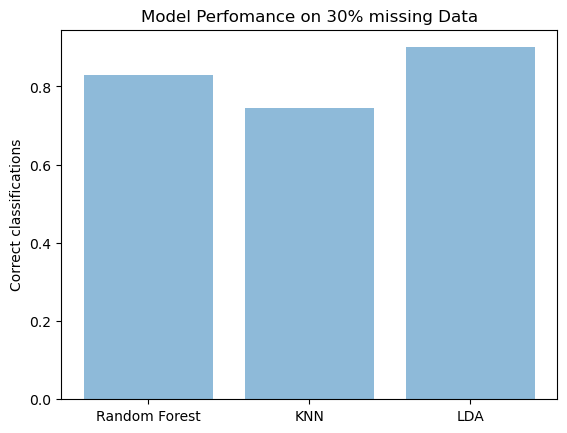

In [6]:
#Test performance on 30 % data missing
method = 0
datasetPollution = 0.3
pixelPollution = 0.3
poluted_X,poluted_y,indexofpolution = generatePollutedData(X_train_clean,y_train_clean,method,datasetPollution,pixelPollution,featureImportances)
generate_bar(poluted_X,poluted_y,X_test,y_test,10,"Model Perfomance on 30% missing Data")

Examine commonly mislabelled images

Best k value: 7
Mislabelled RF: 7 [ 2  6 12 17 22 29 35]
Mislabelled KNN: 8 [ 2  4 12 22 27 28 33 34]
Mislabelled LDA: 5 [ 2  4 22 23 35]
Mislabelled by two or more: 5 [ 2  4 12 22 35]
Mislabelled unique: 13 [ 2  4  6 12 17 22 23 27 28 29 33 34 35]


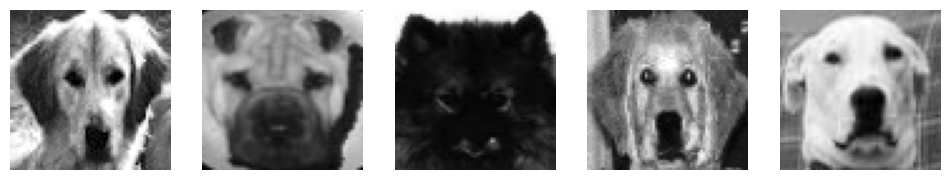

In [7]:
mislabelled_rf = Random_forest(X_train_clean,y_train_clean)[1]
mislabelled_knn = knnClassification(X_train_clean,y_train_clean)[1]
mislabelled_LDA = LDAClassification(X_train_clean,y_train_clean)[2]

print("Mislabelled RF:", len(mislabelled_rf), mislabelled_rf)
print("Mislabelled KNN:", len(mislabelled_knn), mislabelled_knn)
print("Mislabelled LDA:", len(mislabelled_LDA), mislabelled_LDA)

intersect1_2 = np.intersect1d(mislabelled_rf, mislabelled_knn)
intersect1_3 = np.intersect1d(mislabelled_rf, mislabelled_LDA)
intersect2_3 = np.intersect1d(mislabelled_knn, mislabelled_LDA)
union_temp = np.union1d(intersect1_2, intersect1_3)
union_final = np.union1d(union_temp, intersect2_3)
print("Mislabelled by two or more:", len(union_final), union_final)

mislabelled_unique = np.unique(np.concatenate((mislabelled_rf, mislabelled_knn, mislabelled_LDA), axis=0))
print("Mislabelled unique:", len(mislabelled_unique), mislabelled_unique)

image_indices = union_final

f, ax = plt.subplots(1,len(image_indices), figsize=(12,12))
    
for i,j in enumerate(image_indices):
    ax[i].imshow(catsAndDogs.loc[j].values.reshape((64,64)).T)
    ax[i].axis('off') 

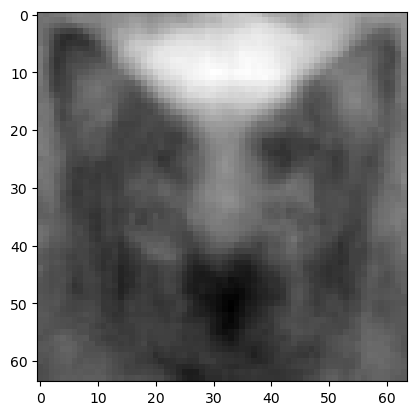

In [8]:
## Single Value Decomposition
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=2)            # Create matrix of 20 components

datasetTSVD = tsvd.fit_transform(catsAndDogs)   # Fit data to said 20 components
datasetTSVD_reconstructed = tsvd.inverse_transform(datasetTSVD) # Invert transform to original dimensions

testVisualisation = np.reshape(datasetTSVD_reconstructed[6],(64,64)).T
plt.imshow(testVisualisation)


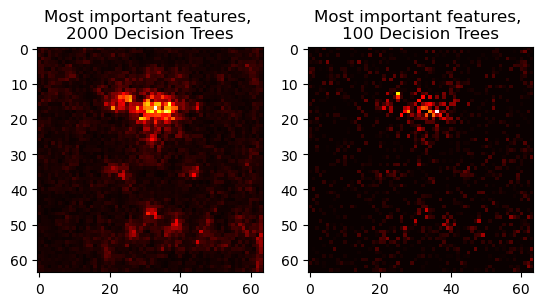

In [9]:
## Random Forest Feature Importance
forest = RandomForestClassifier(n_estimators=2000,random_state=1234567)
forest.fit(catsAndDogs,labels)

featureImportances = forest.feature_importances_
weight_vector = featureImportances.copy()
featureImportances = np.reshape(featureImportances,(64,64)).T


plt.subplot(1,2,1)
plt.title("Most important features, \n2000 Decision Trees")
plt.imshow(featureImportances, cmap="hot")

## Once again for a lower set of n_estimators

forest = RandomForestClassifier(n_estimators=100,random_state=1234567)
forest.fit(catsAndDogs,labels)

featureImportances = forest.feature_importances_
featureImportances = np.reshape(featureImportances,(64,64)).T

plt.subplot(1,2,2)
plt.title("Most important features, \n100 Decision Trees")
plt.imshow(featureImportances,cmap="hot")


### Theme 2a ###

In [10]:
# Define function to visualize pollution 
def visualize_pollution(image_indices, polluted_images):
    f, ax = plt.subplots(1,3, figsize=(12,12))
    
    for i,j in enumerate(image_indices):
        ax[i].imshow(polluted_images.loc[j].values.reshape((64,64)).T)
        ax[i].axis('off') 

Pollute random fraction of the pixels of a random fraction of the images

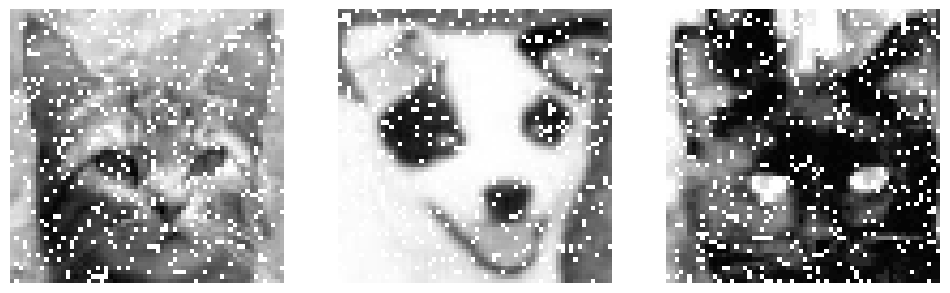

In [11]:
image_fraction = 0.1
pixel_fraction = 0.1

random_images = np.random.choice(catsAndDogs.shape[0], int(image_fraction*catsAndDogs.shape[0]), replace=False)

polluted_images = catsAndDogs.copy()

for i in random_images:
    im = catsAndDogs.loc[i]
    
    random_pixels = np.random.choice(4096, int(pixel_fraction*4096), replace=False) 
    
    im[random_pixels] = np.nan
    polluted_images.loc[i] = im

random_plot_images = np.random.choice(random_images, 3, replace=False)

visualize_pollution(random_plot_images, polluted_images)


#### Imputation ####

In [12]:
from sklearn.impute import SimpleImputer # univariate imputation
mean_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train_mean_imputed = mean_imputer.fit_transform(polluted_images)

from sklearn.impute import KNNImputer # Nearest neighbor imputation
kNN_imputer = KNNImputer(n_neighbors=2, weights="uniform")
X_train_kNN_imputed = kNN_imputer.fit_transform(polluted_images)

In [13]:
# Define function to compare resulting imputed image to original and polluted
def visualize_imputations(image_indices, polluted_images, X_train_mean_imputed, X_train_kNN_imputed):
    for i in image_indices:
        original = catsAndDogs.loc[i].values.reshape((64,64)).T
        polluted = polluted_images.loc[i].values.reshape((64,64)).T
        mean_imputed = X_train_mean_imputed[i].reshape((64,64)).T
        kNN_imputed = X_train_kNN_imputed[i].reshape((64,64)).T
        
        f, ax = plt.subplots(1,4, figsize=(16,16))
        ax[0].imshow(polluted)
        ax[0].set_title('Polluted')
        ax[0].axis('off')
        
        ax[1].imshow(mean_imputed)
        ax[1].set_title('Imputed (mean)')
        ax[1].axis('off')
        
        ax[2].imshow(kNN_imputed)
        ax[2].set_title('Imputed (kNN)')
        ax[2].axis('off')

        ax[3].imshow(original)
        ax[3].set_title('Original')
        ax[3].axis('off')
        plt.show()

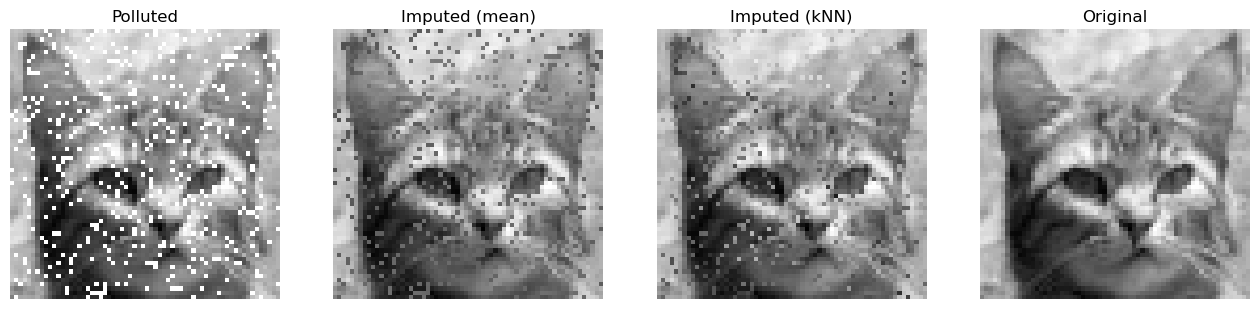

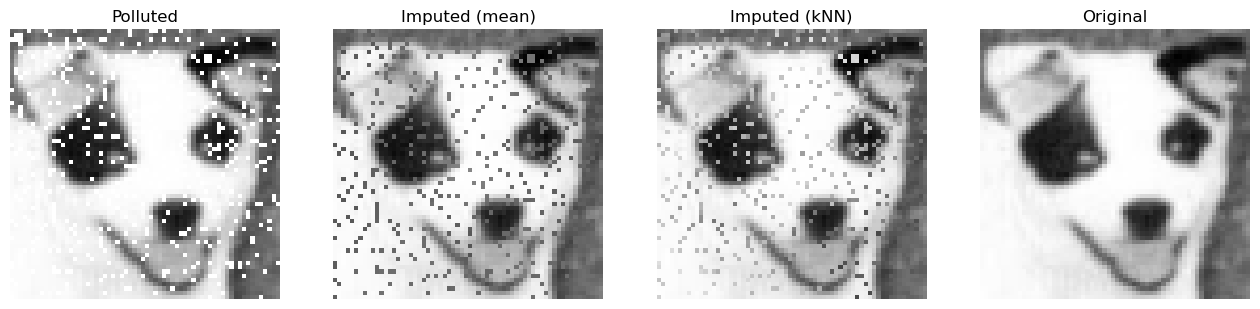

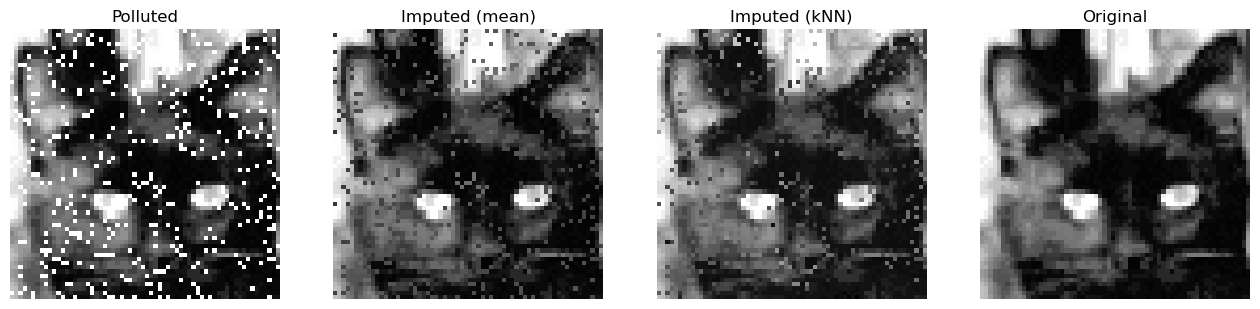

In [14]:
visualize_imputations(random_plot_images, polluted_images, X_train_mean_imputed, X_train_kNN_imputed)

Remove a random fraction of the significant pixels for a random subset of the images

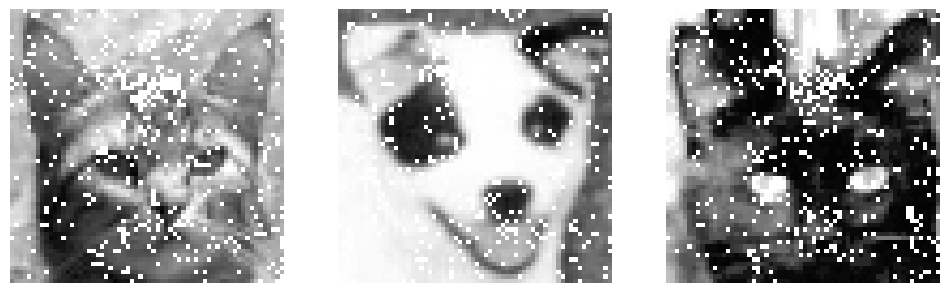

In [15]:
image_fraction = 0.1
pixel_fraction = 0.1

polluted_images = catsAndDogs.copy()

for i in random_images:
    im = catsAndDogs.loc[i]
    
    random_pixels = np.random.choice(4096, int(pixel_fraction*4096), replace=False, p = weight_vector) # 2000 estimators
    
    im[random_pixels] = np.nan
    polluted_images.loc[i] = im

visualize_pollution(random_plot_images, polluted_images)

Univariate and kNN imputation

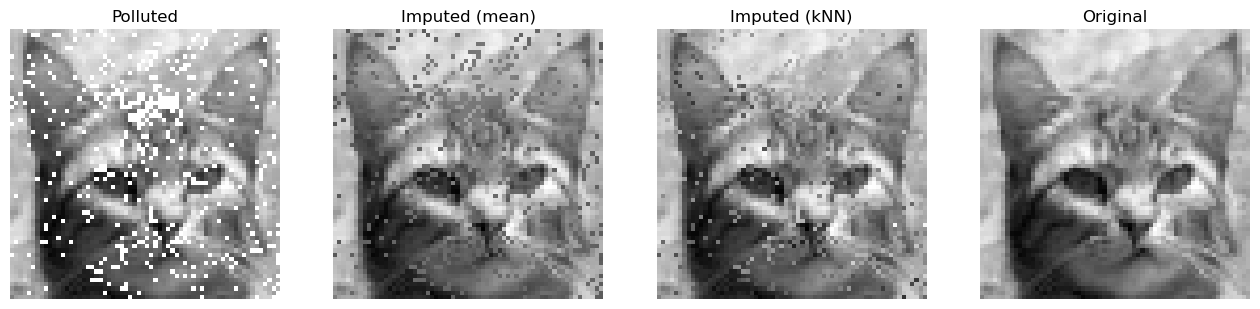

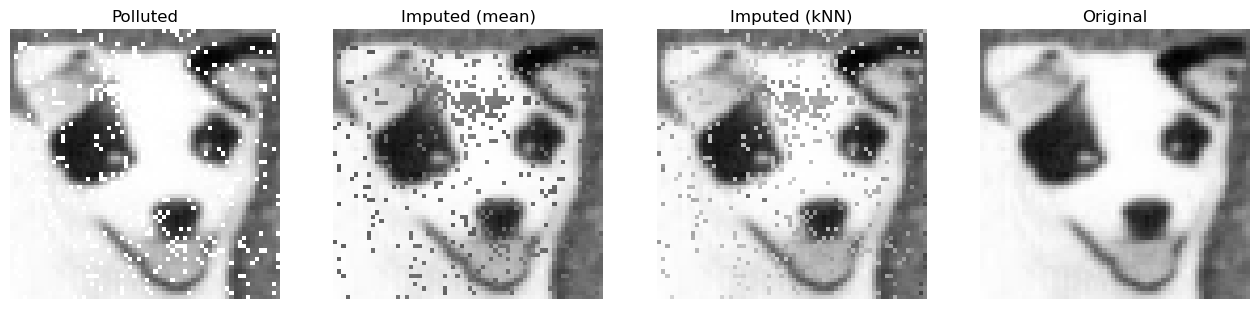

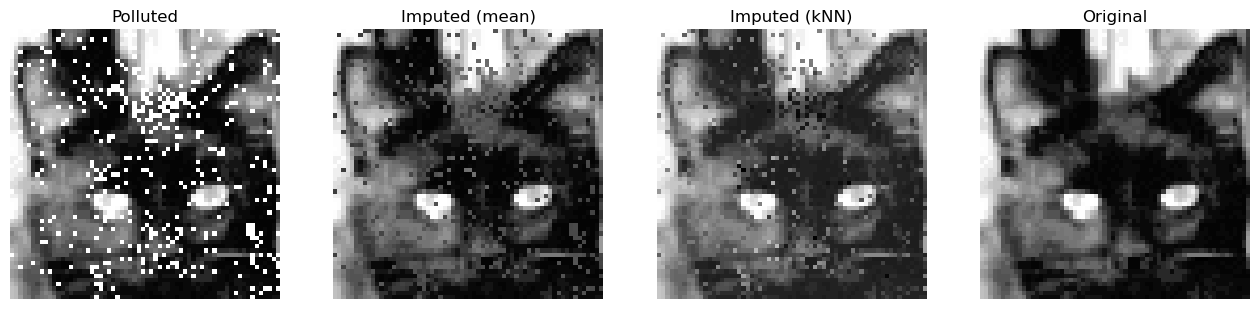

In [16]:
# Cleaning the data with different types of imputation 
from sklearn.impute import SimpleImputer # univariate imputation
mean_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train_mean_imputed = mean_imputer.fit_transform(polluted_images)

from sklearn.impute import KNNImputer # neearest neighbor imputation
kNN_imputer = KNNImputer(n_neighbors=2, weights="uniform")
X_train_kNN_imputed = kNN_imputer.fit_transform(polluted_images)

visualize_imputations(random_plot_images, polluted_images, X_train_mean_imputed, X_train_kNN_imputed)

### Performance across pollution levels ###

Initialization of the models

In [17]:
# Models run

from sklearn.neighbors import KNeighborsClassifier


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
X_train, X_test, y_train, y_test = train_test_split(catsAndDogs, labels, test_size=0.2, random_state=1234567)


def knnClassification(X_train, X_test, y_train):

  # Define k-fold cross validation object
  k_values = list(range(1, 20))
  num_folds = 10
  kf = KFold(n_splits=num_folds, shuffle=True)
  mean_scores = [] # Will contain the mean cross validation scores for each k value


  # Loop over k values to test
  for k in k_values:
      # Create kNN classifier with k neighbors
      knn = KNeighborsClassifier(n_neighbors=k)
      
      # Use cross_val_score to perform k-fold cross validation and calculate mean accuracy
      scores = cross_val_score(knn, X_train, y_train, cv=kf, scoring='accuracy')
      mean_scores.append(np.mean(scores))

  best_k = k_values[np.argmax(mean_scores)]
  print(f"Best k value: {best_k}")


  # Evaluate the classifier on the test set
  knn = KNeighborsClassifier(n_neighbors=best_k)
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)

  # TSNE plot
  #visualize(X_test,color=y_pred,title=f"KNN, frac mislabelled = {fraction}")
  return accuracy

def Random_forest(X_train, X_test, y_train):
  estimator_range = range(10, 101, 10)

  cv_scores = []

  for n_estimators in estimator_range:
      clf_rf = RandomForestClassifier(n_estimators=n_estimators)
      scores = cross_val_score(clf_rf, X_train, y_train, cv=5, scoring='accuracy')
      cv_scores.append(scores.mean())
  optimal_n = estimator_range[cv_scores.index(max(cv_scores))]
  # Create Random Forest classifier and fit the model
  clf_rf = RandomForestClassifier(n_estimators=optimal_n) ## Tuneable parameters. Cross validation?
  clf_rf.fit(X_train, y_train)

  # Predict test set and calculate accuracy
  y_pred_rf = clf_rf.predict(X_test)
  accuracy_rf = accuracy_score(y_test, y_pred_rf)
  return (accuracy_rf)


def LDAClassification(X_train, X_test,y_train):
  clf = LDA()
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  # Save variable for plot
  #visualize(X_test,color=y_pred,title=f"LDA, frac mislabelled = {fraction}")
  accuracy = accuracy_score(y_test, y_pred)
  

  importances = clf.coef_[0]

  return accuracy, importances  
print(y_train)
#y_train = labels
knnClassification(X_train,X_test,y_train)
Random_forest(X_train,X_test,y_train)
LDAClassification(X_train,X_test,y_train)


[0 1 1 0 1 1 1 0 0 1 1 0 1 1 0 1 0 1 0 0 1 1 0 0 1 0 0 1 0 1 0 1 0 1 0 0 1
 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 1 0 1 0 0 1 1 1 1 0 0 1 0 1 1 1
 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1 1 0 0 1 0 0 1 1 1 0 1 0 0 1 0 0 0 1 1 1 1
 0 1 0 0 0 0 1 1 0 0 0 0 1 1 0 1 1 0 0 1 0 1 0 0 1 1 1 1 0 0 1 1 0 1 1 1 1
 1 0 0 0 1 0 0 1 0 1]
Best k value: 15


(0.875,
 array([ 0.0001628 ,  0.00030285,  0.00035816, ..., -0.00029069,
        -0.00060473, -0.00099226]))

In [18]:
#Creating the performance vs pollution data
from sklearn.impute import KNNImputer # neearest neighbor imputation
from sklearn.impute import SimpleImputer # univariate imputation
X_train_org, X_test, y_train, y_test = train_test_split(catsAndDogs, labels, test_size=0.2, random_state=1234567)
image_fraction = 0.9
pixel_fraction = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
#X_train_org.loc[164]
perf_kNN, perf_rf, perf_LDA = [], [], []
#pe_kNN_avg, pe_rf_avg, pe_LDA_avg = 0, 0, 0
perf_kNN_mat, perf_rf_mat, perf_LDA_mat = [], [], []
tot_runs=10
np.random.seed(13341232) 
random_images = np.random.choice(X_train_org.shape[0], int(image_fraction*X_train_org.shape[0]), replace=False)
print(catsAndDogs.shape[0])
print(random_images)
for pix in pixel_fraction:
  pe_kNN_list, pe_rf_list, pe_LDA_list = [], [], []
  print("In run ", pix)
  for run in range(tot_runs):
    polluted_images = X_train_org.copy()
    for i in random_images:
        #print(X_train_org.iloc[i])
        #print(X_train_org.iloc[i])
        #print(X_train_org.get(i))
        im = X_train_org.iloc[i]
        
        random_pixels = np.random.choice(4096, int(pix*4096), replace=False, p = weight_vector) # 2000 estimators , p = weight_vector
        
        im[random_pixels] = np.nan
        polluted_images.iloc[i] = im

    kNN_imputer = KNNImputer(n_neighbors=2, weights="uniform")
    X_train_KNN_imputed = kNN_imputer.fit_transform(polluted_images)
    X_train = X_train_KNN_imputed

  #y_train = labels
    perf_kNN = knnClassification(X_train,X_test.values, y_train)
    perf_rf  = Random_forest(X_train,X_test.values, y_train)
    perf_LDA, imp_LDA = LDAClassification(X_train,X_test.values, y_train)

    pe_kNN_list.append(perf_kNN) 
    pe_rf_list.append(perf_rf)
    pe_LDA_list.append(perf_LDA)
  #print(pe_kNN)
  perf_kNN_mat.append(pe_kNN_list)
  perf_rf_mat.append(pe_rf_list)
  perf_LDA_mat.append(pe_LDA_list)

# perf_kNN_mat.append(perf_kNN_list)

#visualize_imputations(random_plot_images, polluted_images, X_train_mean_imputed, X_train_kNN_imputed)

198
[106 142  99  44  77 115 116  95 124 108  56  73  82  60  93  48  16 127
  72  62  34  57  32 105  53   3  40 132  87  59 135 114  23  68  45   0
   1  54 126 144 140 100 123  96  61 139  19  22 101 111  94  89  80 130
 119  39 147  35 155 102   4  38  66  46 113  26  75  71  30  17  31  29
  98  76  91  70 125  64 129  58  24 153  79 143  49  51 149 150 145 117
 154  65   7   6  69 137 122   2  86 148  25  42  27  13  12 118   5  41
  74  10  43  55   8 133 152 109 131 151  78  14 134 146  85 157  83  47
 141 120  37 136 156  20 128  18 112  63  88 103  52  21  92 104]
In run  0.05
Best k value: 9
Best k value: 14
Best k value: 7
Best k value: 5
Best k value: 17
Best k value: 13
Best k value: 11
Best k value: 3
Best k value: 5
Best k value: 11
In run  0.1
Best k value: 13
Best k value: 3
Best k value: 9
Best k value: 11
Best k value: 7
Best k value: 11
Best k value: 15
Best k value: 11
Best k value: 11
Best k value: 11
In run  0.2
Best k value: 15
Best k value: 1
Best k value: 13


In [ ]:
# Plotting the data 
import seaborn as sns
import statistics as stats
plt.clf() 
pixel_fraction = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
pixel_fraction_plt = [100*x for x in pixel_fraction]
pan_kNN_mat =  pd.DataFrame(data=perf_kNN_mat)
pan_rf_mat = pd.DataFrame(data=perf_rf_mat)
pan_LDA_mat = pd.DataFrame(data=perf_LDA_mat)

runs =["Performance","Pollution"]
#print(runs)
Ll_kNN = []
print(np.shape(perf_kNN_mat))
for i in range(len(perf_kNN_mat)):
    for j in range(tot_runs):
      Ll_kNN.append([perf_kNN_mat[i][j],pixel_fraction_plt[i]])

Ll_rf = []
print(perf_rf_mat)
print(np.shape(perf_rf_mat))
for i in range(len(perf_rf_mat)):
    for j in range(tot_runs):
      Ll_rf.append([perf_rf_mat[i][j],pixel_fraction_plt[i]])

Ll_LDA = []
print(np.shape(perf_LDA_mat))
for i in range(len(perf_LDA_mat)):
    for j in range(tot_runs):
      Ll_LDA.append([perf_LDA_mat[i][j],pixel_fraction_plt[i]])


print(Ll_kNN)
kNN_mat = pd.DataFrame(data=Ll_kNN, columns=runs)
rf_mat = pd.DataFrame(data=Ll_rf, columns=runs)
LDA_mat = pd.DataFrame(data=Ll_LDA, columns=runs)

#kNN_mat = pd.DataFrame(data=perf_kNN_mat, columns=runs)
print(kNN_mat.iloc[0,:])
print(kNN_mat.iloc[:,0])
print(kNN_mat)
print(np.shape(kNN_mat))
# 
#
#plt.show()
# plt.error
#sns.lineplot(data=kNN_mat, x=kNN_mat.iloc[2,:], y=)
sns.lineplot(data=LDA_mat, x="Pollution", y="Performance")
sns.lineplot(data=kNN_mat, x="Pollution", y="Performance")
#sns.lineplot(data=kNN_mat, x="Pollution", y="Performance")
#sns.lineplot(data=kNN_mat, x="Pollution", y="Performance")
sns.lineplot(data=rf_mat, x="Pollution", y="Performance")
plt.legend(['LDA','' ,'kNN' ,''  ,'Random Forest', ''])
plt.title('Performance vs pixel pollution')
plt.ylim((0.5,1))

plt.show()
#sns.lineplot(data=flights, x="year", y="passengers")